# Baseline Models

In [ ]:
# !pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 cuml-cu12

In [ ]:
# !pip install -U nvidia-nvjitlink-cu12 nvidia-nccl-cu12

In [ ]:
# import os, sys, subprocess, site, shutil

# # Put pip's temp dir on the same filesystem as ~/.local to avoid "Invalid cross-device link"
# tmpdir = os.path.expanduser("~/.local/pip-tmp")
# os.makedirs(tmpdir, exist_ok=True)

# env = os.environ.copy()
# env["TMPDIR"] = tmpdir

# pkgs = [
#   "cudf-cu12","cuml-cu12",
#   "libcudf-cu12","libcuml-cu12",
#   "rmm-cu12","libraft-cu12","librmm-cu12","pylibraft-cu12","pylibcudf-cu12",
#   "libkvikio-cu12",
#   "cupy-cuda12x","numba-cuda",
#   "rapids-logger","treelite",
#   "cuda-toolkit","cuda-python","cuda-bindings","cuda-core","cuda-pathfinder",
#   "nvidia-nvjitlink-cu12","nvidia-nccl-cu12",
#   "nvidia-cublas-cu12","nvidia-cuda-cccl-cu12","nvidia-cuda-nvcc-cu12","nvidia-cuda-nvrtc-cu12",
#   "nvidia-cufft-cu12","nvidia-curand-cu12","nvidia-cusolver-cu12","nvidia-cusparse-cu12",
#   "nvidia-libnvcomp-cu12","nvtx",
# ]

# # Uninstall in one go
# cmd = [sys.executable, "-m", "pip", "uninstall", "-y"] + pkgs
# print("Running:", " ".join(cmd))
# subprocess.check_call(cmd, env=env)

# print("\nDone. You should restart the kernel now.")


In [ ]:
# import os, sys, glob, subprocess, ctypes, site

# print(sys.version)
# print(subprocess.check_output(["nvidia-smi", "-L"]).decode())

# base = site.getusersitepackages()

# # 1) Build LD_LIBRARY_PATH (dedup + avoid empty entries)
# candidates = [
#     f"{base}/libcuml/lib64",
#     f"{base}/libcudf/lib64",
#     f"{base}/librmm/lib64",
#     f"{base}/libraft/lib64",
#     f"{base}/libkvikio/lib64",
#     f"{base}/rapids_logger/lib",
#     f"{base}/rapids_logger/lib64",
#     f"{base}/nvidia/nvjitlink/lib",
#     f"{base}/nvidia/nccl/lib",
#     f"{base}/nvidia/*/lib",
#     f"{base}/nvidia/*/lib64",
# ]

# lib_dirs = []
# for pat in candidates:
#     for d in glob.glob(pat):
#         if os.path.isdir(d) and d not in lib_dirs:
#             lib_dirs.append(d)

# old = [p for p in os.environ.get("LD_LIBRARY_PATH", "").split(":") if p]
# new = lib_dirs + [p for p in old if p not in lib_dirs]
# os.environ["LD_LIBRARY_PATH"] = ":".join(new)
# print("LD_LIBRARY_PATH set to:\n", os.environ["LD_LIBRARY_PATH"])

# # 2) Helper: find a library anywhere under site-packages
# def find_first(filename):
#     hits = glob.glob(base + f"/**/{filename}", recursive=True)
#     return hits[0] if hits else None

# # 3) Absolute paths to key libs
# librapids_logger = find_first("librapids_logger.so")
# librmm           = find_first("librmm.so")
# libnvjitlink     = find_first("libnvJitLink.so.12")
# libnccl          = find_first("libnccl.so.2")
# libcumlpp        = find_first("libcuml++.so")

# for name, path in [
#     ("librapids_logger.so", librapids_logger),
#     ("librmm.so", librmm),
#     ("libnvJitLink.so.12", libnvjitlink),
#     ("libnccl.so.2", libnccl),
#     ("libcuml++.so", libcumlpp),
# ]:
#     print(f"{name} -> {path}")
#     if not path or not os.path.exists(path):
#         raise FileNotFoundError(f"Missing {name} under {base}")

# # 4) Preload deps with RTLD_GLOBAL so libcuml++ can resolve them
# GLOBAL = getattr(ctypes, "RTLD_GLOBAL", 0)
# for dep in [librapids_logger, librmm, libnvjitlink, libnccl]:
#     ctypes.CDLL(dep, mode=GLOBAL)
# print("Preloaded deps OK")

# # 5) Now load libcuml++ (should no longer fail on librmm)
# ctypes.CDLL(libcumlpp, mode=GLOBAL)
# print("Loaded libcuml++.so OK")

# # 6) Imports
# import cudf, cuml
# print("cudf:", cudf.__version__)
# print("cuml:", cuml.__version__)


In [1]:
import polars as pl
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score
import cudf

In [2]:
data_dir = Path.home() / "teams/b13-domain-2/ca_data/"

X_train = pl.scan_parquet(data_dir / "X_train.parquet")
y_train = pl.scan_parquet(data_dir / "y_train.parquet")

X_test = pl.scan_parquet(data_dir / "X_test.parquet")
y_test = pl.scan_parquet(data_dir / "y_test.parquet")

X_validation = pl.scan_parquet(data_dir / "X_validation.parquet")
y_validation = pl.scan_parquet(data_dir / "y_validation.parquet")

In [3]:
X_train_cudf = cudf.DataFrame.from_arrow(X_train.collect(engine="streaming").to_arrow())
y_train_cudf = cudf.Series(y_train.collect(engine="streaming").to_numpy().ravel())

## Logistic Regression

In [4]:
from cuml.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=500, class_weight='balanced')
logreg.fit(X_train_cudf, y_train_cudf)

[2026-02-12 15:20:47.747] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


LogisticRegression()

In [6]:
X_test_cudf = cudf.DataFrame.from_arrow(X_test.collect(engine="streaming").to_arrow())
y_test_arr = y_test.collect(engine="streaming").to_numpy().ravel()

In [6]:
y_pred_test = logreg.predict(X_test_cudf).to_numpy()
y_pred_proba = logreg.predict_proba(X_test_cudf)[1].to_numpy()

# print(f"\nTrain accuracy: {accuracy_score(y_pred_train, y_train_arr):.4f}")
print(f"Test accuracy: {accuracy_score(y_pred_test, y_test_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_arr, y_pred_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_arr, y_pred_test))

print(f"\nROC-AUC Score: {roc_auc_score(y_test_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test_arr, y_pred_proba):.4f}")

Test accuracy: 0.7466

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.85  41980704
           1       0.00      0.83      0.00     28843

    accuracy                           0.75  42009547
   macro avg       0.50      0.79      0.43  42009547
weighted avg       1.00      0.75      0.85  42009547


Confusion Matrix:
[[31341157 10639547]
 [    4850    23993]]

ROC-AUC Score: 0.8703

PR-AUC: 0.0063


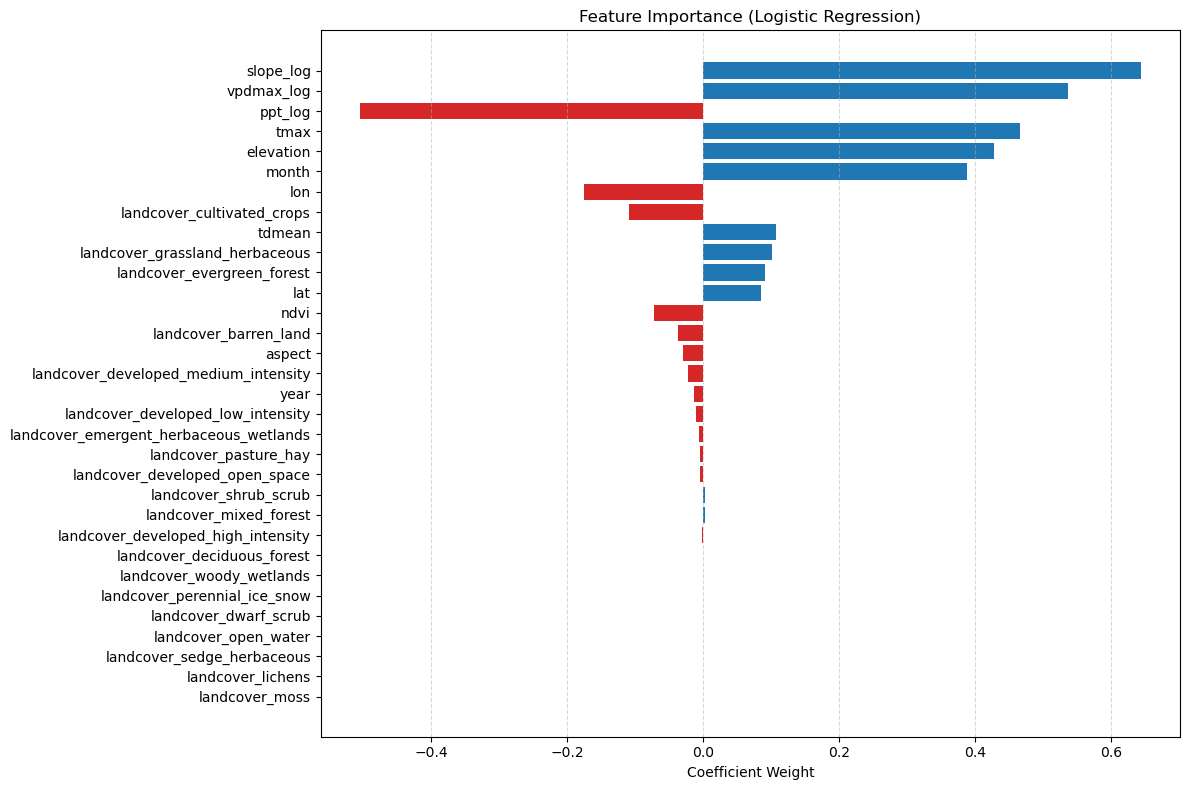

In [7]:
feature_names = X_train.collect_schema().names()
weights_df = pd.DataFrame({
    'feature': feature_names,
    'weight': logreg.coef_.to_numpy().flatten()
})

weights_df_sorted = weights_df.sort_values(by='weight', key=lambda x: x.abs(), ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))

colors = ['#1f77b4' if x > 0 else '#d62728' for x in weights_df_sorted['weight']]

plt.barh(weights_df_sorted['feature'], weights_df_sorted['weight'], color=colors)

plt.gca().invert_yaxis()

plt.xlabel('Coefficient Weight')
plt.title('Feature Importance (Logistic Regression)')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

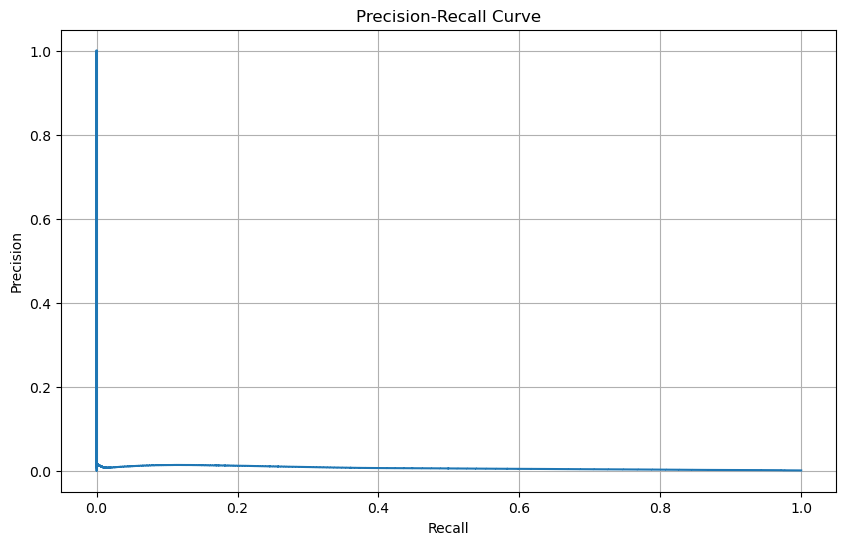

Recall 10%: Precision = 0.013, Threshold = 0.9067
Recall 20%: Precision = 0.012, Threshold = 0.8802
Recall 30%: Precision = 0.009, Threshold = 0.8481


In [8]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_arr, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

for target_recall in [0.1, 0.2, 0.3]:
    idx = np.argmin(np.abs(recalls[:-1] - target_recall))
    print(f"Recall {target_recall:.0%}: Precision = {precisions[idx]:.3f}, Threshold = {thresholds[idx]:.4f}")

## Random Forest

In [ ]:
from cuml.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    max_features='sqrt',
    n_bins=32,
    n_streams=1,
    random_state=42,
    verbose=5
)

rfc.fit(X_train_cudf, y_train_cudf)

In [ ]:
y_pred_test = rfc.predict(X_test_cudf).to_numpy()
y_pred_proba = rfc.predict_proba(X_test_cudf)[1].to_numpy()

print(f"Test accuracy: {accuracy_score(y_pred_test, y_test_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_arr, y_pred_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_arr, y_pred_test))

print(f"\nROC-AUC Score: {roc_auc_score(y_test_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test_arr, y_pred_proba):.4f}")

In [ ]:
feature_names = X_train.collect_schema().names()
weights_df = pd.DataFrame({
    'feature': feature_names,
    'weight': rfc.feature_importances_.to_numpy().flatten()
})

weights_df_sorted = weights_df.sort_values(by='weight', key=lambda x: x.abs(), ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))

colors = ['#1f77b4' if x > 0 else '#d62728' for x in weights_df_sorted['weight']]

plt.barh(weights_df_sorted['feature'], weights_df_sorted['weight'], color=colors)

plt.gca().invert_yaxis()

plt.xlabel('Importance Score')
plt.title('Feature Importance (Random Forest)')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## SVM

In [8]:
from cuml.svm import LinearSVC

svm = LinearSVC(
    max_iter=1000
)

svm.fit(X_train_cudf, y_train_cudf)

[2026-02-12 15:26:59.695] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


LinearSVC()

In [9]:
y_pred_test = svm.predict(X_test_cudf).to_numpy()
y_scores = svm.decision_function(X_test_cudf).to_numpy()

print(f"Test accuracy: {accuracy_score(y_pred_test, y_test_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_arr, y_pred_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_arr, y_pred_test))

print(f"\nROC-AUC Score: {roc_auc_score(y_test_arr, y_scores):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test_arr, y_scores):.4f}")

Test accuracy: 0.9993

Classification Report:


/home/gwuwong/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gwuwong/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gwuwong/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0       1.00      1.00      1.00  41980704
           1       0.00      0.00      0.00     28843

    accuracy                           1.00  42009547
   macro avg       0.50      0.50      0.50  42009547
weighted avg       1.00      1.00      1.00  42009547


Confusion Matrix:
[[41980704        0]
 [   28843        0]]

ROC-AUC Score: 0.8112

PR-AUC: 0.0020


## Validation

In [9]:
X_validation_cudf = cudf.DataFrame.from_arrow(X_validation.collect(engine="streaming").to_arrow())
y_validation_arr = y_validation.collect(engine="streaming").to_numpy().ravel()

In [12]:
y_pred_validation = logreg.predict(X_validation_cudf).to_numpy()
y_pred_proba = logreg.predict_proba(X_validation_cudf)[1].to_numpy()

print(f"Validation accuracy: {accuracy_score(y_pred_validation, y_validation_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_validation_arr, y_pred_validation))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation_arr, y_pred_validation))

print(f"\nROC-AUC Score: {roc_auc_score(y_validation_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_validation_arr, y_pred_proba):.4f}")

Validation accuracy: 0.7267

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84  35280437
           1       0.00      0.82      0.00     21703

    accuracy                           0.73  35302140
   macro avg       0.50      0.78      0.42  35302140
weighted avg       1.00      0.73      0.84  35302140


Confusion Matrix:
[[25635372  9645065]
 [    3807    17896]]

ROC-AUC Score: 0.8652

PR-AUC: 0.0035
